In [1]:
import os
import cv2
import math
import imutils
import numpy as np
import xml.etree.ElementTree as ET

from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

from paths import DATASET_IMG, FRONTAL, LATERAL, DATASET_CARS

In [2]:
FRONTALIMAGES = [str(FRONTAL / image_name) for image_name 
                        in os.listdir(FRONTAL)]
    
LATERALIMAGES = [str(LATERAL / image_name) for image_name 
                        in os.listdir(LATERAL)]

In [3]:
def preprocess_image(img_path):
    """Preprocess the image and return required intermediates."""
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bfilter = cv2.bilateralFilter(gray, 11, 17, 17) # reduce noise
    edged = cv2.Canny(bfilter, 30, 200) # detect edges
    return img, gray, edged


def find_license_plate_aspect_ratio(edged):
    """Find and return all contours found in the input image."""
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)
    good_contours = []
    height, width = edged.shape # set H and W of image
    
    # Calculating buffer in terms of pixels
    border_buffer_x = width * 0.2
    border_buffer_y = height * 0.2
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Check if the contour is inside the buffered region
        if (x > border_buffer_x) and (x + w < width - border_buffer_x) and \
           (y > border_buffer_y) and (y + h < height - border_buffer_y):
                aspect_ratio = float(w) / h
                if (1.2 < aspect_ratio < 8):
                    good_contours.append(contour)

    # store all contours that satisfy requirements
    good_contours = sorted(good_contours, key=cv2.contourArea, reverse=True)[:200]
    return None if len(good_contours) == 0 else good_contours


def obtain_sift_features(gray_licensplates):
    """Obtain the sift features of the input image."""
    sift = cv2.SIFT_create()

    #For each image compute their sift features
    sift_features =  list(map(lambda gray_image: sift.detectAndCompute(gray_image, None)[1], gray_licensplates))
    
    # Filter the images that have no sift features. Compress for each image all the sift features found in one row of shape (1, 128)
    sift_features = filter(lambda image_path: image_path is not None, sift_features)
    sift_features = list(map(lambda features: features.sum(0), sift_features))

    sift_features = np.vstack(sift_features)

    return sift_features

### Load classification models

In [4]:
import joblib

svm_clf = joblib.load('svm_model.pkl') # load support vector machine || WE WON'T USE THIS MODEL
logistic_clf = joblib.load('logistic_model.pkl') # load logistic regression model

### Qualitative results

In [5]:
def extract_patch_from_image(img, gray, locations):
    """Obtain the images that belong to the contours detected with Canny."""
    cropped_images = []

    for location in (locations):
        mask = np.zeros(gray.shape, np.uint8)
        cv2.drawContours(mask, [location], 0, 255, -1)
        cv2.bitwise_and(img, img, mask=mask)
        (x, y) = np.where(mask==255)
        (x1, y1) = (np.min(x), np.min(y))
        (x2, y2) = (np.max(x), np.max(y))
        #cropped_image = gray[x1:x2+1, y1:y2+1]
        cropped_image = img[x1:x2+1, y1:y2+1]
        cropped_images.append(cropped_image)
    return cropped_images


# Main method to process the image and visualize the results
def method_3(img_path):
    """Whole pipeline of the image processing."""
    img, gray, edged = preprocess_image(img_path)
    locations = find_license_plate_aspect_ratio(edged)
    if locations is None:
        print("Sorry, license plate not detected.")
        return
    cropped_images = extract_patch_from_image(img, gray, locations)
    return cropped_images
    #return img, locations # Returns the contours that SVM needs to classify

#### Test images

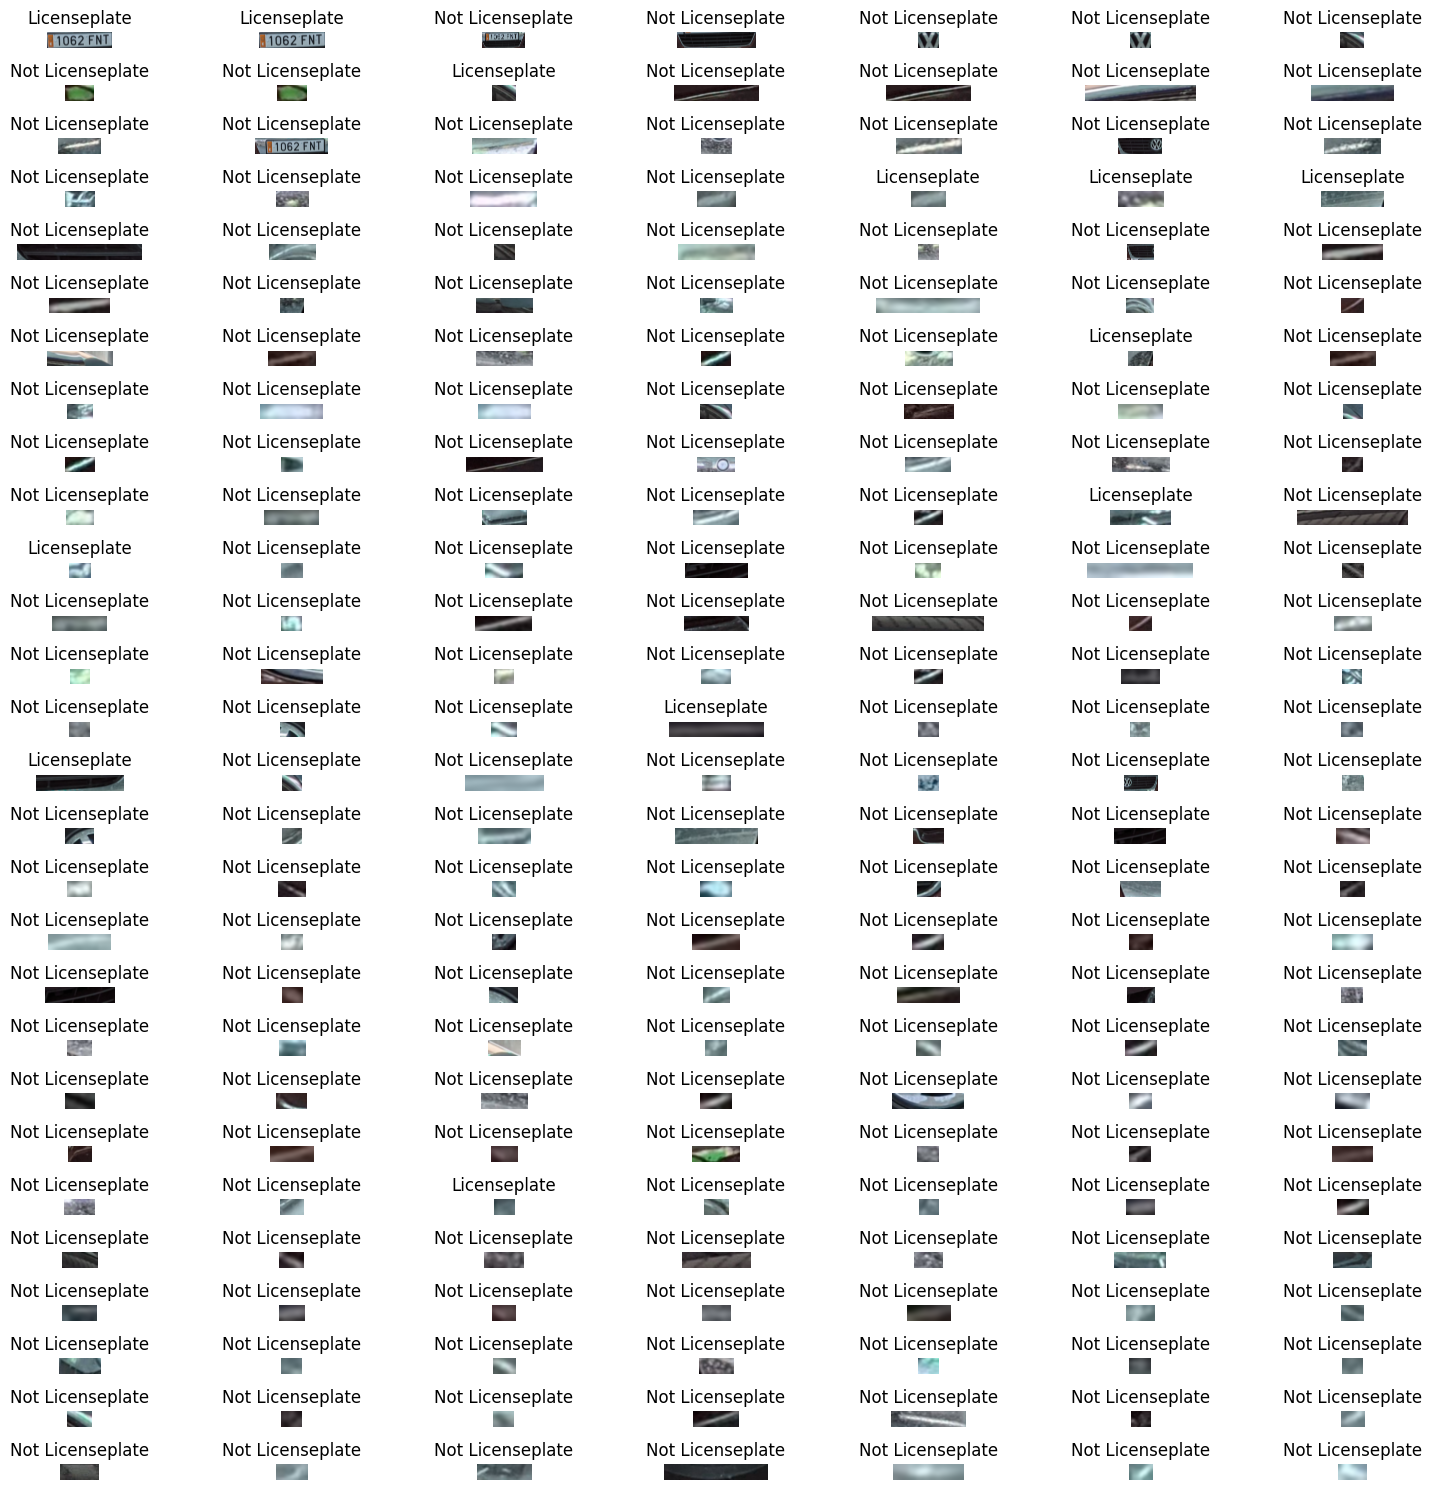

In [6]:
cropped_images = method_3(FRONTALIMAGES[0]) # Well detected frontal: 0 1 2 3 6 9 11 13 14
                                            # Well detected lateral: 0 1 4 5 11
features = obtain_sift_features(cropped_images)

result = logistic_clf.predict(features)
predict_license = np.where(1 == result)[0].tolist()
precit_no_license = np.where(0 == result)[0].tolist()

# Set the figure size to make subplots larger
fig = plt.figure(figsize=(15, 15))

# Create a 10x10 grid of subplots
for i, image in enumerate(cropped_images):
    if (i == (len(cropped_images) // 7) * 7):
        break
    plt.subplot(len(cropped_images) // 7, 7, (i + 1))
    
    if i in predict_license:
        title = "Licenseplate"
    else:
        title = "Not Licenseplate"

    # Adjust the aspect ratio to prevent stretching
    plt.gca().set_aspect('equal', adjustable='box')
    
    # You can adjust the size of the image by setting the interpolation
    plt.imshow(image, cmap='gray', interpolation='bicubic')
    
    plt.title(title)
    plt.axis('off')  # Optional: Hide axis labels

plt.tight_layout()
plt.show()

### Load EasyOCR for Optical Character Recognition

In [7]:
import easyocr
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [9]:
def plot_predicted_license(predict_license):
    """This function plots the list of images extracted from the input."""
    fig = plt.figure(figsize=(12, 12))
    # Create a 10x10 grid of subplots
    for i, pred in enumerate(predict_license, start=1):
        plt.subplot(len(predict_license), 4, i)

        # Adjust the aspect ratio to prevent stretching
        plt.gca().set_aspect('equal', adjustable='box')

        # You can adjust the size of the image by setting the interpolation
        plt.imshow(pred, cmap='gray', interpolation='bicubic')

        plt.axis('off')  # Optional: Hide axis labels

    plt.tight_layout()
    plt.show()

def predict_text(image_path):
    """This function extracts the text that can be found on the input image."""
    cropped_images = method_3(image_path)
    features = obtain_sift_features(cropped_images)

    result = logistic_clf.predict(features)
    predict_license = np.where(1 == result)[0].tolist()

    predicted_immages = [cropped_images[idx] for idx in predict_license]
    license_texts = []
    for img in predicted_immages:
        results = reader.readtext(img, allowlist='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
        texts = [result[1] for result in results]
        if len(texts) == 0:
            continue
        license_texts.append(' '.join(texts))

    if len(license_texts) > 0:
        return max(license_texts, key=len)
    else: return None
    
def compute_time(image_to_recognise, function_to_measure):
    """This function calculates the time spent to compute the function given as input."""
    import time

    start = time.time()
    output = function_to_measure(image_to_recognise)
    end = time.time()
    
    time_spent = end-start
    
    return output, time_spent

In [29]:
from os import walk

total_frontal_images = len(FRONTALIMAGES)
total_lateral_images = len(LATERALIMAGES)

correct_frontal_images = 0
correct_lateral_images = 0

correct_frontal_letters = 0
correct_frontal_numbers = 0

correct_lateral_letters = 0
correct_lateral_numbers = 0

TIME_LIST = []

print('---------FRONTAL IMAGES ARE BEING TESTED----------')

for (dirpath, dirnames, filenames) in walk(FRONTAL):
    for idx, image in enumerate(filenames):
        license_plate = filenames[idx][:-4]
        numbers, letters = license_plate[:-3], license_plate[-3:]
        text, time = compute_time(FRONTALIMAGES[idx], predict_text)
        TIME_LIST.append(time)
        if text is not None:
            if letters in text and numbers in text:
                correct_frontal_images += 1
                correct_frontal_letters += 1
                correct_frontal_numbers += 1
            elif letters in text:
                correct_frontal_letters += 1
            elif numbers in text:
                correct_frontal_numbers += 1
            
print('---------LATERAL IMAGES ARE BEING TESTED----------')
            
for (dirpath, dirnames, filenames) in walk(LATERAL):
    for idx, image in enumerate(filenames):
        license_plate = filenames[idx][:-4]
        numbers, letters = license_plate[:-3], license_plate[-3:]
        text, time = compute_time(LATERALIMAGES[idx], predict_text)
        TIME_LIST.append(time)
        if text is not None:
            if letters in text and numbers in text:
                correct_lateral_images += 1
                correct_lateral_letters += 1
                correct_lateral_numbers += 1
            elif letters in text:
                correct_lateral_letters += 1
            elif numbers in text:
                correct_lateral_numbers += 1

---------FRONTAL IMAGES ARE BEING TESTED----------
---------LATERAL IMAGES ARE BEING TESTED----------


In [31]:
print('Score is calculated in the following way: \"CORRECT_DETECTED_IMAGES\" / \"TOTAL_IMAGES\"\n')

print(f'Total accuracy score on frontal images: {round(float(correct_frontal_images/total_frontal_images), 4)*100}%')
print(f'Accuracy score on letters on frontal images: {round(float(correct_frontal_letters/total_frontal_images), 4)*100}%')
print(f'Accuracy score on numbers on frontal images: {round(float(correct_frontal_numbers/total_frontal_images), 4)*100}%\n')

print(f'Total accuracy score on lateral images: {round(float(correct_lateral_images/total_lateral_images), 4)*100}%')
print(f'Accuracy score on letters on lateral images: {round(float(correct_lateral_letters/total_lateral_images), 4)*100}%')
print(f'Accuracy score on numbers on lateral images: {round(float(correct_lateral_numbers/total_lateral_images), 4)*100}%\n')

print(f'Accuracy score overall: {round(float((correct_frontal_images+correct_lateral_images)/(total_frontal_images+total_lateral_images)), 4)*100}%')
print(f'Accuracy score on letters: {round(float((correct_frontal_letters+correct_lateral_letters)/(total_frontal_images+total_lateral_images)), 4)*100}%')
print(f'Accuracy score on numbers: {round(float((correct_frontal_numbers+correct_lateral_numbers)/(total_frontal_images+total_lateral_images)), 4)*100}%\n')


print(f'The average time of computation for the whole process of a single image is of {round(sum(TIME_LIST)/len(TIME_LIST), 2)} seconds.')

Score is calculated in the following way: "CORRECT_DETECTED_IMAGES" / "TOTAL_IMAGES"

Total accuracy score on frontal images: 40.0%
Accuracy score on letters on frontal images: 46.67%
Accuracy score on numbers on frontal images: 53.33%

Total accuracy score on lateral images: 35.29%
Accuracy score on letters on lateral images: 41.18%
Accuracy score on numbers on lateral images: 35.29%

Accuracy score overall: 37.5%
Accuracy score on letters: 43.75%
Accuracy score on numbers: 43.75%

The average time of computation for the whole process of a single image is of 12.63 seconds.


### Test image - Same as Deep Learning

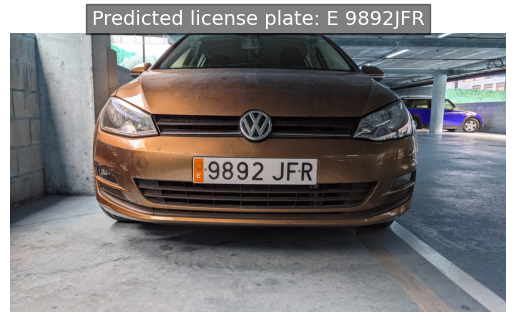

In [36]:
test_image = 'images/Frontal/9892JFR.jpg'

img = cv2.imread(test_image)
prediction = 'Predicted license plate: ' + predict_text(test_image)

fig, ax = plt.subplots()
ax.imshow(img)
plt.title(prediction, color='white', fontsize=14, bbox=dict(facecolor='black', alpha=0.5))
ax.axis('off')
plt.show()

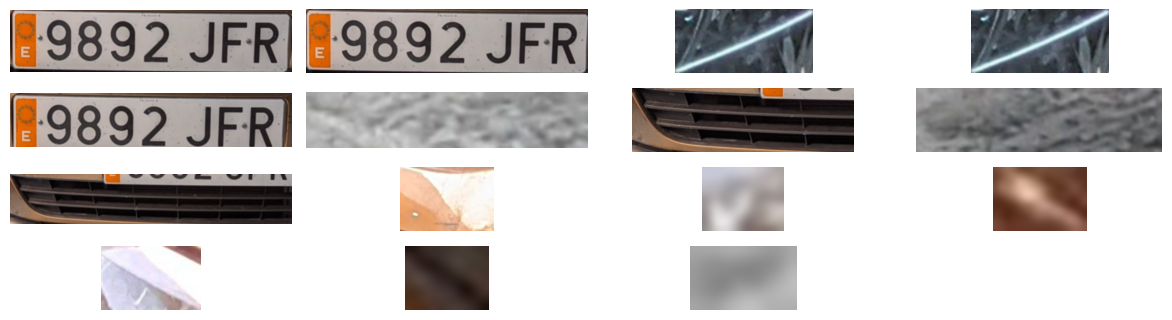

In [32]:
cropped_images = method_3(test_image)
features = obtain_sift_features(cropped_images)

result = logistic_clf.predict(features)
predict_license = np.where(1 == result)[0].tolist()

predicted_images = [cropped_images[idx] for idx in predict_license]

plot_predicted_license(predicted_images)